# NLP Disaster Tweets

## Project Summary

The goal of this project is to classify if tweets are related to emergencies using Natural Language Processing. The dataset includes a training set comprising of tweets that are labeled whether they are related to disasters, and a test set for testing the NLP model.

In [36]:
import re
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## EDA

Below are a set of graphs showing the target distribution for training the model and the length of the text. For cleaning the data I focused on text normalization and removal of noise in the tweets. Removing hyperlinks, changing text to lowercase, removal of special characters as well as common words were done to make each tweet consistent with each other. 

The plan of analysis is to train multiple models to ascertain their effectiveness, and then use the best performing model to generate the predictions for submission. The models I will be using are Logistical Regression and Random Forest, implementing these models using TF-IDF and using LSTM to capture sequential dependencies. 

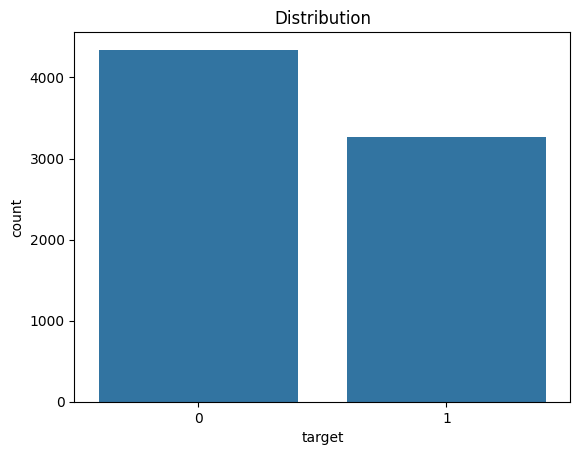

In [38]:
sns.countplot(x = 'target', data = train)
plt.title("Distribution")
plt.show()

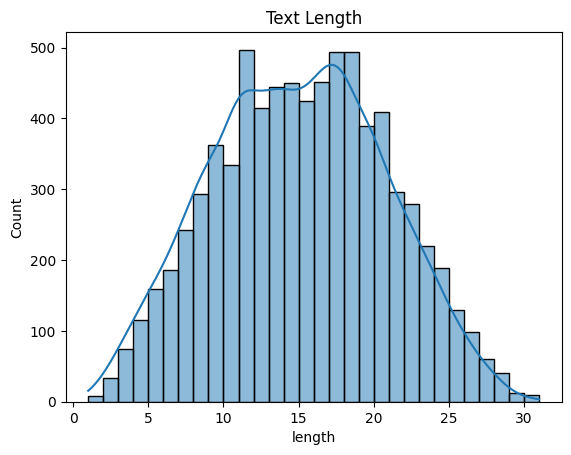

In [39]:
train['length'] = train['text'].apply(lambda x: len(x.split()))
sns.histplot(train['length'], bins = 30, kde = True)
plt.title("Text Length")
plt.show()

In [40]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

train['clean'] = train['text'].apply(clean_text)
test['clean'] = test['text'].apply(clean_text)

In [41]:
train['clean_length'] = train['clean'].apply(lambda x: len(x.split()))
train.head()

,id,keyword,location,text,target,length,clean,clean_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deeds reason earthquake may allah forgive us,7
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,residents asked shelter place notified officer...,11
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,13 000 people receive wildfires evacuation ord...,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,got sent photo ruby alaska smoke wildfires pou...,9


In [42]:
test['clean_length'] = test['clean'].apply(lambda x: len(x.split()))
test.head()

,id,keyword,location,text,clean,clean_length
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,4
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,7
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,10
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan,6


## Model Architecture

For this project I used both traditional machine learning models as well as a LSTM network. I used Logistic Regression and Random Forest, using TF-IDF to assign higher weights to words that appear more frequently in a single tweet but otherwise rare in the dataset. For a more effective result, I used a LSTM model, which can caputre dependencies and contextual relationships between words, making it good for sentiment analysis and text classification. For the LSTM model, I used word embedding find semantic relationships between words, achieving better performance by using current linguistic knowledge while dealing with different length tweets.

In [43]:
vectorizer = TfidfVectorizer(max_features = 10000)
X = vectorizer.fit_transform(train['clean'])
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [44]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

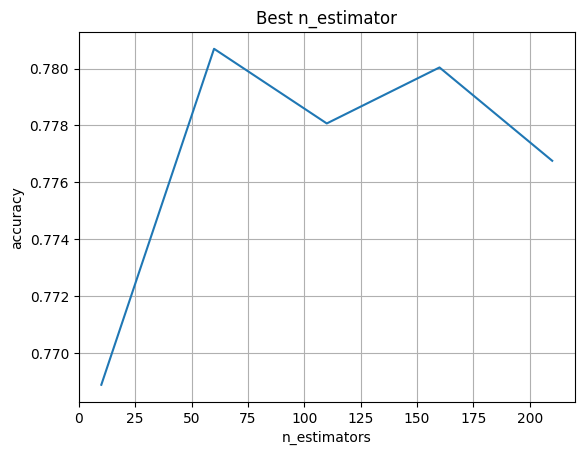

Best n_estimator:  60


In [45]:
def best_n_estimators(X_train, y_train, X_val, y_val, estimators_range):
    accuracies = []
    for n_estimators in estimators_range:
        rf = RandomForestClassifier(n_estimators = n_estimators, random_state = 42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

    best_n = estimators_range[accuracies.index(max(accuracies))]

    plt.plot(estimators_range, accuracies)
    plt.xlabel("n_estimators")
    plt.ylabel("accuracy")
    plt.title("Best n_estimator")
    plt.grid(True)
    plt.show()

    print("Best n_estimator: ", best_n)

    return best_n

estimators_range = range(10, 211, 50)
best_n_estimators= best_n_estimators(X_train, y_train, X_val, y_val, estimators_range)

In [46]:
rf = RandomForestClassifier(n_estimators = 60)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

In [47]:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(train['clean'])
X_seq = tokenizer.texts_to_sequences(train['clean'])
X_seq = pad_sequences(X_seq, maxlen = max_len)

X_train_seq, X_val_seq, y_train, y_val = train_test_split(X_seq, y, test_size = 0.2, random_state = 42)

In [48]:
model = keras.Sequential([
    keras.layers.Embedding(max_words, 128, input_length = max_len),
    keras.layers.LSTM(64, return_sequences = True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs = 5, batch_size = 32)

Epoch 1/5
191/191 [==============================] - 18s 75ms/step - loss: 0.5292 - accuracy: 0.7335 - val_loss: 0.4477 - val_accuracy: 0.7859
Epoch 2/5
191/191 [==============================] - 13s 69ms/step - loss: 0.3096 - accuracy: 0.8688 - val_loss: 0.5038 - val_accuracy: 0.7741
Epoch 3/5
191/191 [==============================] - 14s 71ms/step - loss: 0.2040 - accuracy: 0.9236 - val_loss: 0.5872 - val_accuracy: 0.7649
Epoch 4/5
191/191 [==============================] - 14s 75ms/step - loss: 0.1412 - accuracy: 0.9484 - val_loss: 0.8362 - val_accuracy: 0.7518
Epoch 5/5
191/191 [==============================] - 14s 74ms/step - loss: 0.0987 - accuracy: 0.9631 - val_loss: 0.8346 - val_accuracy: 0.7557


## Results

I improved the model by testing different settings like layer size and learning speed, and tested using various structures including combinations with CNNs. Using a two-layer LSTM with adjusted settings, dropout, and pre-trained word embeddings rendered the best results, providing good accuracy while avoiding overfitting.

Below are the accuracy results of each model used.

In [49]:
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_lr))

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))

print("LSTM Accuracy: ", model.evaluate(X_val_seq, y_val, verbose = 0))

Logistic Regression Accuracy: 0.7898883782009193
Random Forest Accuracy: 0.767564018384767
LSTM Accuracy:  [0.8346279263496399, 0.7557452321052551]


In [50]:
X_test_seq = tokenizer.texts_to_sequences(test['clean'])
X_test_seq = pad_sequences(X_test_seq, maxlen = max_len)
test_preds = model.predict(X_test_seq)

test['target'] = (test_preds > 0.5).astype(int)
test[['id', 'target']].to_csv("submission.csv", index = False)

102/102 [==============================] - 3s 22ms/step


## Conclusion

While the simpler models worked decently, the LSTM with word embeddings performed much better at understanding the context of the given tweets. Further improvements to the model include using more advanced models such as BERT and adding more data to train on.